In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# Loading data
Units are all in mm/d, seems a little weird but if you divide m3/s into m3/d then m3/d divided by the area is m3/(m2d) = m/d -> mm/d: all in one unit

In [30]:
df = pd.read_csv("Forcing.txt", delimiter="	", names=["year","month","day","P","Q","EP"])
df.index = df.apply(lambda x: pd.Timestamp(f'{int(x.year)}-{int(x.month)}-{int(x.day)}'),axis=1)
df.drop(columns=["year","month","day"],inplace=True)
df.head()

,P,Q,EP
1997-08-01,8.888,0.388,1.715079
1997-08-02,0.265,0.517,3.779446
1997-08-03,1.034,0.543,2.157360
1997-08-04,0.000,0.448,4.788141
1997-08-05,0.000,0.428,4.964434


# Set up parameters, arrays and other initialisation steps
_These need to be in a different order than previously implemented: we need to access the parameters every timestep_

In [3]:
# lets start only with one month
df = df.iloc[:365]

In [4]:
# specifiy number of particles
n_particles = 10

In [5]:
# set up storage terms 
# allocate Si, Su, Sf, Ss, Eidt, Eadt, Qtotdt
t_max = len(df)

storage_memory = []
# could be more ellegant with numpy but lets just start with 10 lists of 10 arrays
for i in range(n_particles):
    Si        = np.zeros(t_max) # Interception storage
    Su        = np.zeros(t_max) # Unsaturated Rootzone Storage
    Sf        = np.zeros(t_max) # Fastflow storage
    Ss        = np.zeros(t_max) # Groundwater storage
    Ei_dt     = np.zeros(t_max) # interception evaporation
    Ea_dt     = np.zeros(t_max) # actual evaportation
    Qs_dt_lst = np.zeros(t_max) # list of slow flow 
    Qf_dt_lst = np.zeros(t_max) # list of fast flow
    Q_tot_dt  = np.zeros(t_max) # total flow
    Q_m       = np.zeros(t_max) # Final model prediction
    memory_vector_placeholder = np.zeros((t_max)) # Memory vector placeholder actuall is np.zeros((t_max,T_lag)) - but dependent on T_lag
    storage_memory.append([Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt, Q_m, memory_vector_placeholder])

In [6]:
## Array of parameters min/max bounds
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_in = np.array([0,  100,  0,  5  ])

Note notation 3 is used with p for parameters <br>
<img src="figures\Lecture1A_slide26_notation.png" alt="Lecture1A_slide26_notation" style="height: 300px"/>

In [26]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

# Tlag must be a whole number of days
p_intial[:,5] = np.array(np.round(p_intial[:,5],0),dtype=int)

In [27]:
# inital value array for every particle
p_intial[0]

array([5.76034431e+00, 9.12159770e-01, 6.00384161e+02, 2.51922619e+00,
       2.57743895e-01, 8.00000000e+00, 5.48630234e-02, 4.28219653e-03])

## visualise the initial particle parameters

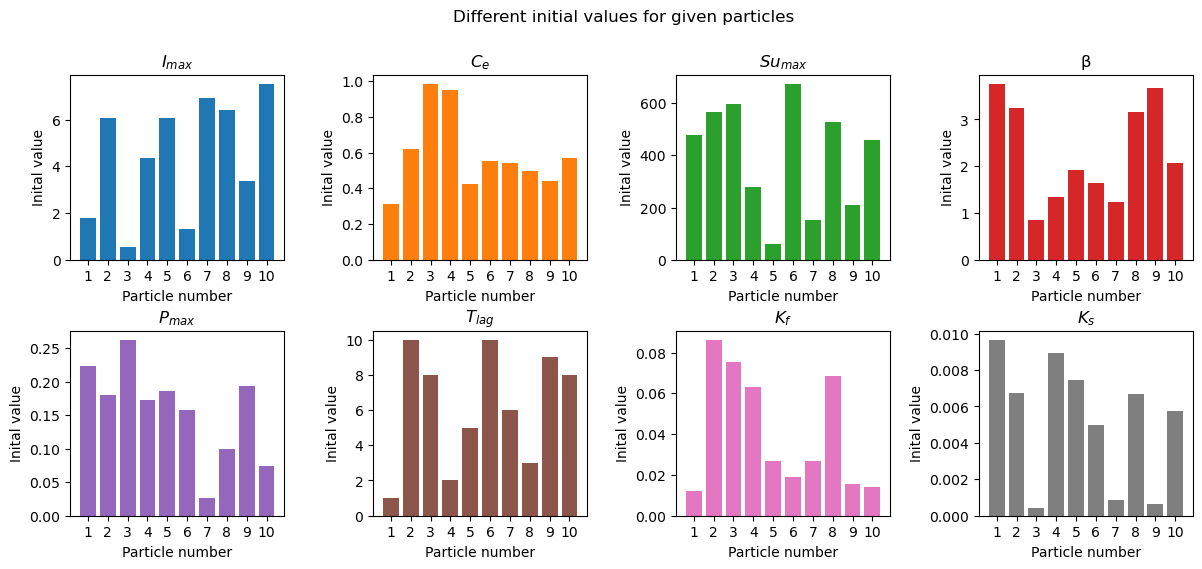

In [9]:
n_params = len(p_intial[0])
fig, ax = plt.subplots(2,n_params//2, figsize=(12,5))
fig.tight_layout(h_pad=3,w_pad=3)
fig.suptitle("Different initial values for given particles",y=1.09)
ax = ax.flatten()
for i in range(n_params):
    ax[i].bar(np.arange(1,n_particles+1,1),np.vstack(p_intial)[:,i], color=F"C{i}")
    ax[i].set_xticks(np.arange(1,n_particles+1,1))
    ax[i].set_xlabel("Particle number")
    ax[i].set_ylabel("Inital value")
    ax[i].set_title(p_names[i])

# Implement functions: 

In [10]:
def Weigfun(T_lag): 
    nmax=int(np.ceil(T_lag))
    if nmax==1: 
        Weigths=float(1)
    else:
        Weigths=np.zeros(nmax)
        th=T_lag/2
        nh=int(np.floor(th))
        for i in range(0,nh): 
            Weigths[i]=(float(i+1)-0.5)/th         
        i=nh

        Weigths[i]=(1+(float(i+1)-1)/th)*(th-int(np.floor(th)))/2+(1+(T_lag-float(i+1))/th)*(int(np.floor(th))+1-th)/2
        for i in range(nh+1, int(np.floor(T_lag))):
            Weigths[i]=(T_lag-float(i+1)+.5)/th

        if T_lag>int(np.floor(T_lag)):
            Weigths[int(np.floor(T_lag))]=(T_lag-int(np.floor(T_lag)))**2/(2*th)

        Weigths=Weigths/sum(Weigths)
    
    return(Weigths)

In [11]:
def HBVMod_forward(par, df, s_in, storage_terms, step_n):
    """
    Function to run the forward part of one timestep of the HBV model     
    parameters
    ----------
    par: array_like
        array/list containing 8 parameters: Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks (floats)
    df: pandas.core.frame.DataFrame
        DataFrame containing 'P', 'Q', 'EP' columns as forcing for the model.
    s_in: array_like
        array/list containing 4 storage terms which are input to the timestep: Si,  Su, Sf, Ss (floats)
    storage_terms: list of arrays
        list of arrays which store: Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt
    step_n: int
        nth step which formard model takes: used to determin which Precipitaion & evaporation to use

    Returns
    ----------
    Obj, df: float, pandas.core.frame.DataFrame
        return of the objective function and corresponding dataframe

    """
    #HBVpareto Calculates values of 3 objective functions for HBV model
    
    # define parameters 
    I_max  = par[0]   # maximum interception
    Ce     = par[1]   # Ea = Su / (sumax * Ce) * Ep
    Su_max = par[2]   # ''
    beta   = par[3]   # Cr = (su/sumax)**beta
    P_max  = par[4]   # Qus = Pmax * (Su/Sumax)
    T_lag  = par[5]   # used in triangular transfer function
    Kf     = par[6]   # Qf=kf*sf
    Ks     = par[7]   # Qs=Ks*Ss
    
    # precipitation is given by the first column, Q0 by the second and  
    # Precipitaion & evaporation are inputs
    Prec   = df.P.iloc[step_n]
    Etp    = df.EP.iloc[step_n]
    
    # For now skip evap
    # Qo     = df.Q.values
    
    # unpack storage terms: 
    # memory vector & Q_m are unused but this makes unpacking easier
    Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt, Q_m, memory_vector = storage_terms
    
    if step_n == 0:
        # initialize the storage coefficients Si, Su, Sf, Ss
        Si[0] = s_in[0]
        Su[0] = s_in[1]
        Sf[0] = s_in[2]
        Ss[0] = s_in[3]

    # time step of one day
    dt = 1

    i = step_n # maybe refactor later but useful for now
    
    P_dt  = Prec * dt
    Ep_dt = Etp  * dt

    # Interception Reservoir
    if P_dt > 0:
        # if there is rain, no evap
        Si[i]    = Si[i] + P_dt               # increase the storage
        Pe_dt    = max((Si[i] - I_max) / dt, 0)
        Si[i]    = Si[i] - Pe_dt 
        Ei_dt[i] = 0                          # if rainfall, evaporation = 0 as too moist 
    else:
        # Evaporation only when there is no rainfall
        Pe_dt    = 0                      # nothing flows in so must be 0
        Ei_dt[i] = min(Ep_dt, Si[i] / dt) # evaporation limited by storage
        Si[i]    = Si[i] - Ei_dt[i] 

    # if not the end, initialise the next storage
    if i < t_max - 1:
        Si[i+1] = Si[i]

    # split flow into Unsaturated Reservoir and Fast flow
    if Pe_dt > 0:
        cr     = (Su[i] / Su_max)**beta
        Qiu_dt = (1 - cr ) * Pe_dt      # flux from Ir to Ur
        Su[i]  = Su[i] + Qiu_dt
        Quf_dt = cr  * Pe_dt            # flux from Su to Sf
    else:
        Quf_dt=0

    # Transpiration
    Ep_dt    = max(0, Ep_dt - Ei_dt[i])        # Transpiration 
    Ea_dt[i] = Ep_dt  * (Su[i] / (Su_max * Ce))
    Ea_dt[i] = min(Su[i], Ea_dt[i])            # limited by water in soil 
    Su[i]    = Su[i] - Ea_dt[i]

    # Percolation
    Qus_dt = P_max * (Su[i] / Su_max) * dt # Flux from Su to Ss
    Su[i]  = Su[i] - Qus_dt

    # make the final steps to update next step
    if i < t_max - 1:
        Su[i+1]=Su[i]

    # Fast Reservoir
    Sf[i] = Sf[i] + Quf_dt
    Qf_dt = dt * Kf * Sf[i]
    Sf[i] = Sf[i] - Qf_dt
    if i < t_max -  1:
        Sf[i+1] = Sf[i]

    # Slow Reservoir
    Ss[i] = Ss[i] + Qus_dt
    Qs_dt = Ss[i] * Ks * dt
    Ss[i] = Ss[i] - Qs_dt
    if i < t_max-1:
        Ss[i+1] = Ss[i]

    Q_tot_dt[i] = Qs_dt + Qf_dt
    Qs_dt_lst[i] = Qs_dt
    Qf_dt_lst[i] = Qf_dt
       
    storage_terms = Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt, Q_m, memory_vector
    return storage_terms

In [12]:
def add_time_lag(T_lag, t_max, storage_terms):
    ##### add support for T_lag =0
    
    # unpack terms
    # only really need Q_m & memory vector
    Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt, Q_m, memory_vector = storage_terms
    weights = Weigfun(T_lag) 
    if memory_vector.shape != (t_max, T_lag):
        memory_vector = np.zeros((t_max,T_lag))
    for t in range(t_max): # Go through all time steps
        # Distribute current Q_tot_dt to memory vector
        memory_vector[t,:] += weights*Q_tot_dt[t]
        
        # Extract the latest Qm
        Q_m[t] = memory_vector[t,0]
        
        if t < t_max-1:
            
            # Make a forecast to the next time step
            memory_vector[t+1,:] = np.roll(memory_vector[t,:],-1)  # This cycles the array [1,2,3,4] becomes [2,3,4,1]
            memory_vector[t+1,-1] = 0                              # the next last entry becomes 0 (outside of convolution lag)
    
    storage_terms = Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt, Q_m, memory_vector
    return storage_terms

# First run forward model for all particles and steps to check its working

In [13]:
for particle_n in range(n_particles):
    for step_n in range(t_max):
        storage_memory[particle_n] = HBVMod_forward(p_intial[particle_n], df, s_in, storage_memory[particle_n], step_n)
    T_lag = int(p_intial[particle_n][5]) # fith index - needs to be int
    storage_memory[particle_n] = add_time_lag(T_lag, t_max, storage_memory[particle_n])

## Here we clearly see the lag function working nicely

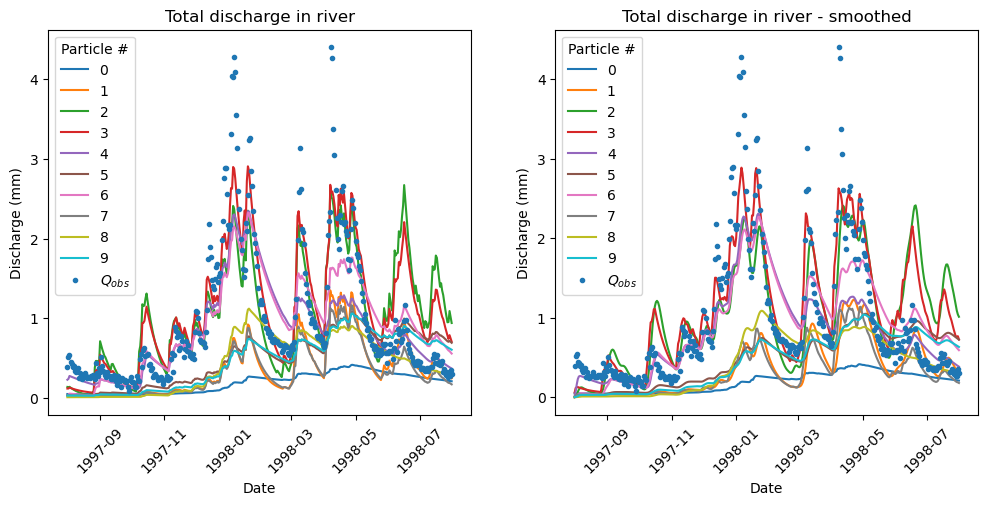

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(121)
for particle_n in range(n_particles):
    Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt, Q_m, memory_vector = storage_memory[particle_n]
    plt.plot(df.index, Q_tot_dt, label=f"{particle_n}")
plt.plot(df.index, df.Q, label="$Q_{obs}$",lw=0, ms=3, marker="o")
plt.legend(title="Particle #")
plt.title("Total discharge in river")
plt.xlabel("Date")
plt.ylabel("Discharge (mm)")
plt.xticks(rotation=45);

plt.subplot(122)
for particle_n in range(n_particles):
    Si, Su, Sf, Ss, Ei_dt, Ea_dt, Qs_dt_lst, Qf_dt_lst, Q_tot_dt, Q_m, memory_vector = storage_memory[particle_n]
    plt.plot(df.index, Q_m, label=f"{particle_n}")
plt.plot(df.index, df.Q, label="$Q_{obs}$",lw=0, ms=3, marker="o")
plt.legend(title="Particle #")
plt.title("Total discharge in river - smoothed")
plt.xlabel("Date")
plt.ylabel("Discharge (mm)")
plt.xticks(rotation=45);

Now that we know it runs normally, we can actually implement the particle filter

In [31]:
# # 'normally' post processing steps after whole run -> still check the WB
# # Check Water Balance
# Sf  = Si[-1] + Ss[-1] + Sf[-1] + Su[-1] # final storage
# s_in = sum(s_in)                          # initial storage
# WB  = sum(Prec) - sum(Ei_dt)- sum(Ea_dt) - sum(Q_tot_dt) + s_in - Sf